# homework 4
### message-passing graph networks with attention

the goals of this assignment:
1. learn to construct a message passing network (learn about DGLs update functions, build edge and node networks)
2. learn to train an edge classifier
3. implement self-attention between nodes on a graph

![theproblem](./problem.jpeg)

## Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML_2023/homework4_2023_shortest_path

/content/drive/MyDrive/ML_2023/homework4_2023_shortest_path


## Dataset

The dataset is made from random graphs, where two points on the graph have been labeled as the start and end points of a path.
the task is to classify the edges of the graph to determine if they are "part of" the shortest path between the two points.

In [ ]:
#!wget https://www.dropbox.com/s/a56v8gjksne63zj/train_data.tar

In [ ]:
#!wget https://www.dropbox.com/s/lt1luqhjludhdxe/test_data.tar

In [ ]:
#!tar -xzf train_data.tar

Note that colab can be quite slow when reading many files from the mounted GDrive space. You have the option to copy the datasets to the `/content` directory to speed this up.

In [ ]:
#!tar -xvf test_data.tar

In [ ]:
#!cp 'train_data.tar' '/content/.'
#!tar -xzf '/content/train_data.tar' -C '/content/'

In [ ]:
#!cp 'test_data.tar' '/content/.'
#!tar -xzf '/content/test_data.tar' -C '/content/'

## Packages

In [3]:
!pip uninstall dgl
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 9.0 MB/s eta 0:00:00


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import dgl
import pandas as pd
import torch
import networkx as nx

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


This is needed to avoid a strange crash I saw

In [ ]:
dgl.use_libxsmm(False)

In [7]:
from dataset import ShortestPathDataset, collate_graphs

In [14]:
training_dataset = ShortestPathDataset('/content/train_data/')
validation_dataset = ShortestPathDataset('/content/test_data/')

100%|██████████| 10000/10000 [00:29<00:00, 342.10it/s]


In [15]:
g = training_dataset[18]

In [16]:
g

Graph(num_nodes=29, num_edges=116,
      ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)})

The nodes of the graph have no real "features" - the node features mark the starting and ending points

starting point (1,0)

ending point (0,1)

In [11]:
g.ndata['node_features']

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

Each edge has a distance associated with it, and the target for training is also stored on the edge data - saying if the edge is part of the path or not

In [12]:
g.edata['distance']

tensor([1.7726, 1.6546, 1.1645, 1.8976, 1.6500, 0.6451, 1.2268, 1.1165, 1.1514,
        0.9349, 1.6361, 1.3388, 1.6955, 1.4689, 1.4927, 1.0446, 0.7330, 1.2344,
        0.2579, 0.9008, 0.3837, 1.3609, 0.8316, 0.6450, 0.5538, 0.9517, 1.4448,
        1.2315, 0.3102, 0.3393, 0.2201, 1.3471, 2.0553, 1.0765, 1.6985, 1.6349,
        1.3490, 0.2891, 1.5096, 0.6596, 1.2275, 0.7765, 0.5579, 0.8842, 1.3902,
        0.6024, 0.9721, 0.9278, 0.2688, 0.5042, 0.2629, 1.7948, 0.3433, 0.5199,
        1.3777, 0.1664, 1.8326, 0.9535, 0.1819, 1.4760, 0.2361, 0.3687, 1.5332,
        1.3678, 1.2536, 0.8805, 0.4851, 1.5713, 1.4930, 1.4738, 1.3957, 1.5607,
        1.2025, 1.0447, 1.5377, 0.3426, 1.2016, 1.3157, 1.5954, 1.2877, 0.4520,
        1.8553, 1.7726, 1.6546, 1.1645, 1.8976, 1.6500, 0.6451, 1.2268, 1.1165,
        1.1514, 0.9349, 1.6361, 1.3388, 1.6955, 1.4689, 1.4927, 1.0446, 0.7330,
        1.2344, 0.2579, 0.9008, 0.3837, 1.3609, 0.8316, 0.6450, 0.5538, 0.9517,
        1.4448, 1.2315, 0.3102, 0.3393, 

In [ ]:
g.edata['on_path']

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

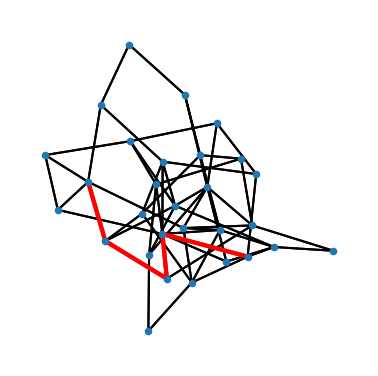

In [34]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(3,3),dpi=150)


nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(g.nodes().data.numpy())
nx_graph.add_edges_from([(e_src.item(),e_dst.item()) for e_src,e_dst in zip(g.edges()[0],g.edges()[1])])

edge_dict = {(s.item(),e.item()) : on_path.item() for s,e,on_path in zip(g.edges()[0],g.edges()[1],
                                                                         g.edata['on_path'])}
edge_list = [e for i,e in enumerate(nx_graph.edges) if edge_dict[e]>0]

pos = nx.spring_layout(nx_graph)

nx.draw( nx_graph ,pos=pos ,ax=ax ,node_size=7,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax,arrows=False)
plt.show()

In [17]:
from torch.utils.data import DataLoader, Subset

Ntrain = len(training_dataset)
Nvalid = 1000

data_loader = DataLoader(Subset(training_dataset,range(Ntrain)), batch_size=500, shuffle=True,
                         collate_fn=collate_graphs, num_workers=0)
validation_data_loader = DataLoader(Subset(validation_dataset,range(Nvalid)), batch_size=500, shuffle=False,
                         collate_fn=collate_graphs, num_workers=0)

In [18]:
for batched_g in data_loader:
    break

In [19]:
batched_g

Graph(num_nodes=16659, num_edges=66636,
      ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)})

## The model

what are the building blocks we need?

![themodel](./model.jpeg)

Here is closer look at what is happening in the Edge update and the Node update:
![theupdates](./updates.jpeg)

in order to implement the edge and node updates, we use DGLs "update_all" interface

short summary:
-------------------
for details look at the DGL documentation, https://docs.dgl.ai/tutorials/blitz/index.html
Or the tutorial
Or ask us on slack if the concept isn't clear.


in model.py you have the basic skeleton. you implement an "edge network" and a "node network"

the edge network will act on all the edges in your graph - it will look at the nodes at the "src" and "dst" (source and destination) of the edge and apply a fully connected network to it

then the node network will have access to a "mailbox" with all the information sent by the edges connected to each node. you sum that "mailbox", add to it the existing node hidden represation, and then apply a fully connected network to update the node represation.

after each step of the update, networks take the node and edge represenations and apply a binary classifier to say if its "on path" or not.
the prediction is added to the previous step prediction, and the final result is compared to the target with BCEWithLogitsLoss. for both nodes and edges


we want to implement the model such that it decorates the nodes and edges of the graph with the prediction (the forward pass of the model doesnt actually return anything)

In [82]:
import MPNN_model
import importlib
importlib.reload(MPNN_model)

<module 'MPNN_model' from '/content/drive/MyDrive/ML_2023/homework4_2023_shortest_path/MPNN_model.py'>

In [83]:
from MPNN_model import Classifier

In [ ]:
net = Classifier(do_attention=True)

In [75]:
net(batched_g)

In [80]:
batched_g.edata['pred']

tensor([-1.2667, -1.2483, -1.3421,  ..., -1.1085, -1.1532, -1.0934],
       device='cuda:0', grad_fn=<AddBackward0>)

## Class imbalance
Often in classification problems, one class outweights the other. In our case, the majority of edges have a ground-truth class of 0, not 1 (roughly a factor of 10). We will use this factor in the loss function to put more weight on the getting the positive predictions right.

[61664.  4320.]
14.274074074074074


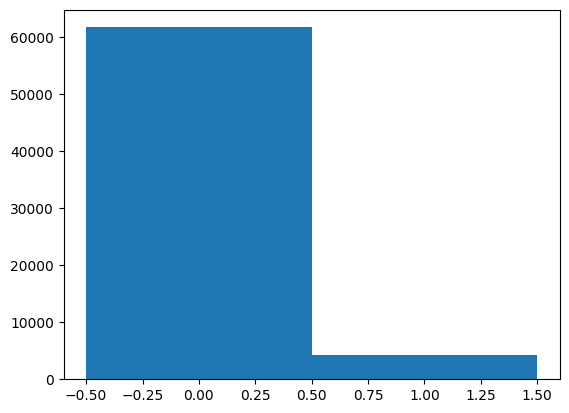

In [101]:
h = plt.hist( batched_g.edata['on_path'].data.numpy() ,bins=[-0.5,0.5,1.5])
print(h[0])
print(h[0][0]/h[0][1])
plt.show()

## Loss, optimizer

In [85]:
import torch.nn as nn
import torch.optim as optim

pos_weight = torch.Tensor([10])
if torch.cuda.is_available():
    pos_weight = pos_weight.to(torch.device('cuda'))

loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [86]:
if torch.cuda.is_available():
    print('Moving net to cuda')
    net.cuda()

Moving net to cuda


## Training loop

In [87]:
from tqdm.notebook import tqdm
from evaluate import compute_f1_and_loss

n_epochs = 100
best_f1 = -1.
training_loss_vs_epoch = []
validation_loss_vs_epoch = []
training_f1_vs_epoch = []
validation_f1_vs_epoch = []


pbar = tqdm( range(n_epochs) )

for epoch in pbar:

    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description(
              ' train f1:'+'{0:.5f}'.format(validation_f1_vs_epoch[-1]) +
              ' valid f1:'+'{0:.5f}'.format(validation_f1_vs_epoch[-1])
              )

    net.train() # put the net into "training mode"
    for batched_g in tqdm(data_loader):

        if torch.cuda.is_available():
            batched_g = batched_g.to(torch.device('cuda'))


        optimizer.zero_grad()
        net(batched_g)
        edge_target = batched_g.edata['on_path']
        edge_pred = batched_g.edata['pred']

        loss = loss_func(edge_pred,edge_target)
        loss.backward()
        optimizer.step()

    net.eval() #put the net into evaluation mode
    train_f1, train_loss = compute_f1_and_loss(data_loader,net)
    valid_f1, valid_loss = compute_f1_and_loss(validation_data_loader,net)

    training_loss_vs_epoch.append(train_loss)
    training_f1_vs_epoch.append( train_f1 )

    validation_loss_vs_epoch.append(valid_loss)
    validation_f1_vs_epoch.append(valid_f1)

    if len(validation_loss_vs_epoch) > 0:
        if len(validation_loss_vs_epoch)==1 or validation_f1_vs_epoch[-1] > best_f1:
            torch.save(net.state_dict(), 'trained_model.pt')
            best_f1 = validation_f1_vs_epoch[-1]

    print('train_f1: ', train_f1)
    print('valid_f1: ', valid_f1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.3174479249069457
valid_f1:  0.3138793526018441


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.31698237009552016
valid_f1:  0.3140422706476683


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.3420587344989968
valid_f1:  0.3413122583385654


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.3986871125387556
valid_f1:  0.39369666114735014


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.36456352590848967
valid_f1:  0.36516795324613144


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.41993963548852725
valid_f1:  0.4184454418950208


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.4244301798187331
valid_f1:  0.42274069354352223


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5070646019768836
valid_f1:  0.5066253780421557


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5120269305279879
valid_f1:  0.5087523277122903


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.49494607136321483
valid_f1:  0.49297195080409884


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5214992181162396
valid_f1:  0.5177890513267821


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5823765357562063
valid_f1:  0.5805588470944872


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5621853133039528
valid_f1:  0.556647439966058


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5854302450248972
valid_f1:  0.5832929510878374


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5712406744536113
valid_f1:  0.5664653107505118


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5843467189413212
valid_f1:  0.5807872877875921


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.6080465992131193
valid_f1:  0.603433248656377


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.6106628090036341
valid_f1:  0.6072889689143648


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.618997860750605
valid_f1:  0.6130904951156827


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.5190963777883969
valid_f1:  0.5142768079479877


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.6601586728828265
valid_f1:  0.6542910296324281


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.6832467910049994
valid_f1:  0.6780972990404847


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7619135422000989
valid_f1:  0.7540171852270482


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7088973482099156
valid_f1:  0.7032207926169397


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7345112950057302
valid_f1:  0.7248658317777401


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7690288098570616
valid_f1:  0.7599343184837031


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7261417807769953
valid_f1:  0.7258275831316423


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7454229551184255
valid_f1:  0.7401730087633748


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7272607434684308
valid_f1:  0.7198841444051535


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7655275870066425
valid_f1:  0.7579641156391465


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.766137131372536
valid_f1:  0.7568083654688058


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7496733362303476
valid_f1:  0.7439819124223982


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8025678491790781
valid_f1:  0.7908973807746865


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8135765532787873
valid_f1:  0.8056922334003191


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7909658817802218
valid_f1:  0.7810053277015515


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.6895616770929238
valid_f1:  0.6861082561933789


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7782364083497947
valid_f1:  0.7686399399804571


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.7950811906626459
valid_f1:  0.7849482595686784


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8208644605139951
valid_f1:  0.8143437208733091


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8372613013597512
valid_f1:  0.8291120231425456


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8232983844427036
valid_f1:  0.8150932343244075


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8349159645051253
valid_f1:  0.8302036760228312


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8508585428982823
valid_f1:  0.8411328183309472


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8402677477429675
valid_f1:  0.8253983915510978


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8213361850868166
valid_f1:  0.8095943427005978


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.835127054561945
valid_f1:  0.8218897713735305


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8319664519327088
valid_f1:  0.8212209301529825


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8319448321717732
valid_f1:  0.825124353767178


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8417686166842958
valid_f1:  0.8328839648185808


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8587999535522486
valid_f1:  0.8502716843579924


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8379042322084969
valid_f1:  0.8258089705865772


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8854518836731498
valid_f1:  0.8796032498808057


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8609548418512808
valid_f1:  0.8524207857183856


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8654346774685356
valid_f1:  0.8570548682587841


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8772117405768852
valid_f1:  0.8679968902961391


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8478902942958447
valid_f1:  0.8415896025152122


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8873048879904473
valid_f1:  0.8801218742508802


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8708246722419599
valid_f1:  0.8656916262369253


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8953548435099836
valid_f1:  0.8888888887941953


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8975061005013584
valid_f1:  0.8913654937227229


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.865091417108414
valid_f1:  0.8568838754298637


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8821795157346262
valid_f1:  0.8751547667276975


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8924124452196366
valid_f1:  0.8870832458705091


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8846087954098462
valid_f1:  0.8782617734818315


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8837086367196113
valid_f1:  0.8713615990035174


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8735635720239616
valid_f1:  0.863015095791206


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8933907503940258
valid_f1:  0.89033476745825


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8640587068456265
valid_f1:  0.8553648498589416


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8892582197809179
valid_f1:  0.8789583332417752


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8980595043141629
valid_f1:  0.8928290404560846


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8447733012960378
valid_f1:  0.8400493217420419


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8975156423398796
valid_f1:  0.8883067895129603


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8944544015122564
valid_f1:  0.8876246149707578


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9293048428863454
valid_f1:  0.9161759039114782


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9126234435282029
valid_f1:  0.9060826728522079


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8815572146636527
valid_f1:  0.8749295485089994


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9294325988285798
valid_f1:  0.924630324329659


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9144093252776072
valid_f1:  0.9055374591866783


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9109384597050578
valid_f1:  0.9079409696839893


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8873160950874951
valid_f1:  0.8734373384777934


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9218133065274251
valid_f1:  0.9127751378106095


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8834234614244862
valid_f1:  0.8753011121033979


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8966528269983649
valid_f1:  0.8910434462668577


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.900551963403243
valid_f1:  0.8928159411753732


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9224032818234075
valid_f1:  0.912630836714287


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9115148805625292
valid_f1:  0.9019275576252989


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9088660012645057
valid_f1:  0.9025836508997688


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9124873204750149
valid_f1:  0.9052079429529296


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.8934833102707052
valid_f1:  0.8861852024243555


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9168723392690966
valid_f1:  0.9102571011792964


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.912585939282056
valid_f1:  0.9039740383142018


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9128790710991287
valid_f1:  0.90659370128155


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9269042870472408
valid_f1:  0.9214254576153633


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9323905399234038
valid_f1:  0.930214639413295


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9290593228066637
valid_f1:  0.9172312861491428


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9117432763649426
valid_f1:  0.9059099636328237


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9246531575826125
valid_f1:  0.9176139438218454


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9070189592481368
valid_f1:  0.9023651341055152


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9211356127858921
valid_f1:  0.9129080755033389


  0%|          | 0/20 [00:00<?, ?it/s]

train_f1:  0.9254238388284476
valid_f1:  0.9189834925153145


## Loss and accuracy (f1)
The f1 score measures the accuracy of the model in a way that accounts for the class imbalance.\
See https://towardsdatascience.com/the-f1-score-bec2bbc38aa6

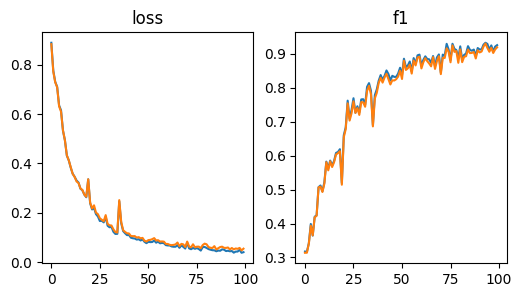

In [88]:
fig,ax = plt.subplots(1,2,figsize=(6,3))

ax[0].set_title('loss')
ax[0].plot(training_loss_vs_epoch,label='train')
ax[0].plot(validation_loss_vs_epoch,label='valid')
ax[1].set_title('f1')
ax[1].plot(training_f1_vs_epoch,label='train')
ax[1].plot(validation_f1_vs_epoch,label='valid')
plt.show()

## Load the best model

In [89]:
net.load_state_dict(torch.load('trained_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

## Discrimination

In [90]:
for batched_g in validation_data_loader:
    break
net.eval()
if torch.cuda.is_available():
    net.cuda()
    batched_g = batched_g.to(torch.device('cuda'))
net(batched_g)
if torch.cuda.is_available():
    predictions = batched_g.edata['pred'].cpu().data.numpy()
    sigmoid_predictions =  torch.sigmoid(batched_g.edata['pred']).cpu().data.numpy()
    targets = batched_g.edata['on_path'].cpu().data.numpy()
else:
    predictions = batched_g.edata['pred'].data.numpy()
    sigmoid_predictions =  torch.sigmoid(batched_g.edata['pred']).data.numpy()
    targets = batched_g.edata['on_path'].data.numpy()

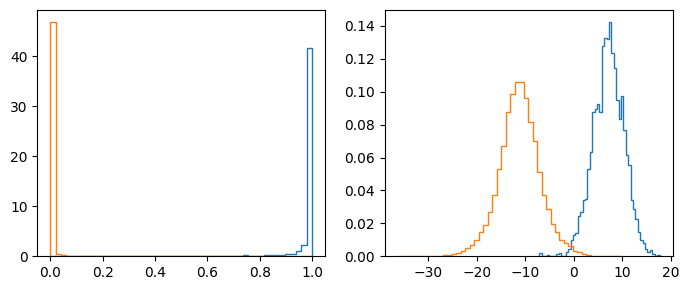

In [91]:
import numpy as np
fig,ax = plt.subplots(1,2,figsize=(7,3))

ax[0].hist(sigmoid_predictions[targets==1],histtype='step',bins=np.linspace(0,1,50),density=True)
ax[0].hist(sigmoid_predictions[targets==0],histtype='step',bins=np.linspace(0,1,50),density=True)

ax[1].hist(predictions[targets==1],histtype='step',bins=50,density=True)
ax[1].hist(predictions[targets==0],histtype='step',bins=50,density=True)

plt.tight_layout()
plt.show()

## Examples of target and predicted
Note that it is not fully clear what exactly the attention is doing, but it may be playing some role.

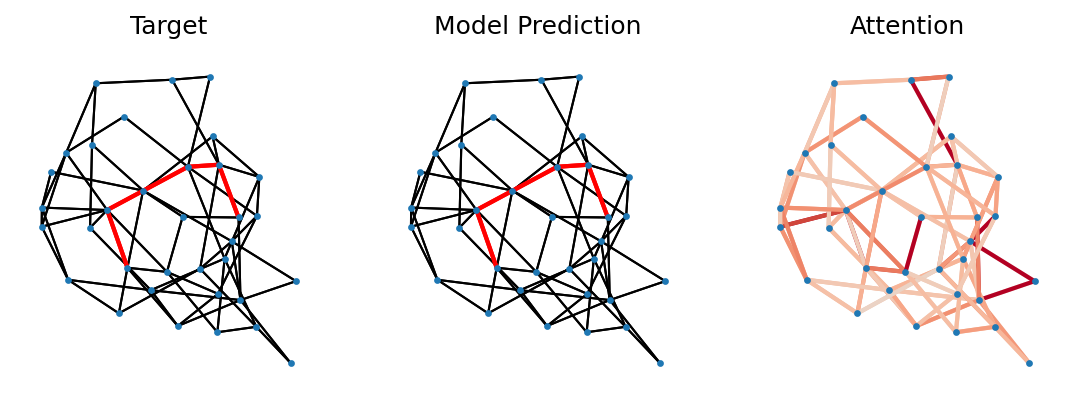

In [98]:
fig,ax = plt.subplots(1,3,figsize=(9,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')
ax[2].set_title('Attention')
net.eval()
net.cpu()

g = validation_dataset[np.random.randint(Nvalid)]
net(g)


output_pred = torch.sigmoid(g.edata['pred']).data.numpy()
output_attn = g.edata['attn'].data.numpy()

nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(g.nodes().data.numpy())
nx_graph.add_edges_from([(es.item(),ee.item()) for es,ee in zip(g.edges()[0],g.edges()[1])])

edge_dict = {(s.item(),e.item()) : on_path.item() for s,e,on_path in zip(g.edges()[0],g.edges()[1],
                                                                         g.edata['on_path'])}

edge_prediction_dict = {(s.item(),e.item()) : pred.item() for s,e,pred in zip(g.edges()[0],g.edges()[1],
                                                                         output_pred)}

edge_list = [e for i,e in enumerate(nx_graph.edges) if edge_dict[e]>0]

predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if edge_prediction_dict[e]>0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

### make the edge color proportional to the attention
colors = plt.cm.coolwarm(output_attn)
colors = colors - np.min(colors)
colors = colors/np.max(colors)

nx.draw( nx_graph ,pos=pos ,ax=ax[2] ,node_size=5, arrows=False, edge_color=colors, width=2)

plt.show()

## You need >80% f1 to pass

In [100]:
from evaluate import evaluate_on_dataset
f1, loss = evaluate_on_dataset('/content/test_data/')
print(f1, loss)

100%|██████████| 10000/10000 [00:27<00:00, 357.84it/s]


0.9186899902080574 0.06604657431735712
